<img src="pic.png" width="1000px">

In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch.nn as nn
from einops import rearrange
from torchsummary import summary
import torch.optim as optim
import math
from tqdm import tqdm
import cv2
import numpy as np
from torch import Tensor



import lightning as L

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
class VQ_VAE(L.LightningModule):
    def __init__(self, input_dim, codebook_size, encoding_dim, hidden_dim, beta):
        super().__init__()

        assert len(input_dim) == 3, "Input dimension must be 3D"
        assert len(encoding_dim) == 3, "Encoding dimension must be 3D"

        # Set the dimensions
        self.input_dim = input_dim
        self.codebook_size = codebook_size
        self.encoding_dim = encoding_dim
        self.hidden_dim = hidden_dim
        self.beta = beta

        # Unwrap input dimension, extract the number of channels, height and width
        self._input_c = input_dim[0]
        self._input_h = input_dim[1]
        self._input_w = input_dim[2]
        self._input_dim_flat = self._input_c * self._input_h * self._input_w

        # Unwrap encoding dimension
        self._embedding_dim = encoding_dim[0]
        self._encoding_h = encoding_dim[1]
        self._encoding_w = encoding_dim[2]

        # Calculate flat encoding dimension
        self._encoding_dim_flat = self._embedding_dim * self._encoding_h * self._encoding_w
    

        # Setup encoder layers
        self.enc_fc1 = nn.Linear(self._input_dim_flat, self.hidden_dim)
        self.enc_fc2 = nn.Linear(self.hidden_dim, self._encoding_dim_flat)
        self.relu = nn.ReLU()

        # Setup decoder layers
        self.dec_fc1 = nn.Linear(self._encoding_dim_flat, self.hidden_dim)
        self.dec_fc2 = nn.Linear(self.hidden_dim, self._input_dim_flat)
        self.sigmoid = nn.Sigmoid()

        # Setup codebook embeddings
        self.codebook = nn.Embedding(self.codebook_size, self._embedding_dim)
        assert self.codebook.weight.requires_grad == True, "Codebook should be learnable"
        # TODO: Initialize codebook uniformly, like in the paper
        # nn.init.uniform_(self.codebook.weight, -1/self.codebook_size, 1/self.codebook_size)

        # For now we initialize randomly the codebook vectors. We act like stupid, then if it works, we use uniform like in other implementations.
 
    def encode(self, x):
        """
        x: Input image of shape (b, c, h, w)
        Output: z - encoded image of shape (b, h, w, c)
        """
        assert x.shape[1:] == (self._input_c, self._input_h, self._input_w)

        # Run the layers
        x = rearrange(x, 'b c h w -> b (c h w)') # Flatten the input
        x = self.relu(self.enc_fc1(x))
        x = self.relu(self.enc_fc2(x))

        # Unflatten, last dimension is embedding dim
        x = rearrange(x, 'b (c h w) -> b h w c', c=self._embedding_dim, h=self._encoding_h, w=self._encoding_w)

        return x
    
    def decode(self, z_q):
        """        
        Input: z_q: Quantized encodings of shape (b h w c)

        Returns the reconstructed image x_hat of shape (b c h w)
        """
        # Rearrange so we work on the values, also flatten because of fully-connected layers
        z_q = rearrange(z_q, 'b h w c -> b (c h w)')

        # Run the layers
        x = self.relu(self.dec_fc1(z_q))
        x = self.relu(self.dec_fc2(x))
        x_hat = self.sigmoid(x)

        # Rearrange back to image shape
        x_hat = rearrange(x_hat, 'b (c h w) -> b c h w', c=self._input_c, h=self._input_h, w=self._input_w)

        return x_hat
    
    def quantize(self, z):
        """
        z_e: (batch_size, encoding_height, encoding_width, embedding_dim)

        Get closest (euclidean distance) codebook vector z_q given z.

        Returns quantized encodings z_q of shape (b h w c)
        """
        assert z.shape[1:] == (self._encoding_h, self._encoding_w, self._embedding_dim)

        flat_input = rearrange(z, 'b h w c -> (b h w) c')

        # TODO: Replace this by my own distances calculation
        # Equation: ||z - e||^2 = ||z||^2 + ||e||^2 - 2 * <z,e>
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
            + torch.sum(self.codebook.weight**2, dim=1)
            - 2 * torch.matmul(flat_input, self.codebook.weight.t()))

        #distances = self.calculate_distances(z)

        # Distances is shape (batch, height, width, embed_dim)
        # Get the index of the closest codebook vector
        min_indices = torch.argmin(distances, dim=1)

        # We now have matrix of one-hot vectors, with "1" at the index of the closest codebook vector, given by "min_indices"
        one_hot = nn.functional.one_hot(min_indices, num_classes=self.codebook_size)

        # Now to get the value of the closest codebook vector, we multiply the one-hot matrix with the codebook matrix
        z_q = torch.matmul(one_hot.float(), self.codebook.weight)

        # Reshape back
        z_q = rearrange(z_q, '(b h w) c -> b h w c', b=z.shape[0], h=self._encoding_h, w=self._encoding_w)

        return z_q

    def forward(self, x):
        assert x.shape[1:] == (self._input_c, self._input_h, self._input_w)

        # Encode
        z = self.encode(x)

        # Quantize the latent vector
        z_q = self.quantize(z)

        # Add streight through estimator
        z_q = z + (z_q - z).detach()
        
        # Decode
        x_reconstructed = self.decode(z_q)

        # The output image should have the same shape as the input image
        assert x_reconstructed.shape == x.shape

        # Return x hat (and also some other stuff for loss calculation and debugging)
        return x_reconstructed, z, z_q

    def training_step(self, batch, batch_idx):
        images, _ = batch
    
        # Forward pass
        x_hat, z_e, z_q = self(images)

        # Calculate loss
        # Reconstruction loss
        recon_loss = nn.BCELoss(reduction='sum')(x_hat, images)
        # recon_loss = nn.functional.mse_loss(x_hat, images)

        # Quantization loss
        quant_loss = nn.functional.mse_loss(z_q, z_e.detach())

        # Commitment loss
        commit_loss = nn.functional.mse_loss(z_q.detach(), z_e)

        # Total loss
        loss = recon_loss + quant_loss + self.beta * commit_loss

        values = {"loss": loss, "recon_loss": recon_loss, "quant_loss": quant_loss, "commit_loss": commit_loss}
        self.log_dict(values)

        return loss
    
    def configure_optimizers(self):
        lr = 1e-3
        optimizer = optim.Adam(self.parameters(), lr=lr)
        return optimizer


In [21]:
# Model
input_dim = (3, 32, 32)
codebook_size = 512

embedding_dim = 64 # Dimension of each codebook vector
encoding_dim = (embedding_dim, 8, 8)

hidden_dim = 1024

beta = 0.25

In [22]:
model = VQ_VAE(input_dim, codebook_size, encoding_dim, hidden_dim, beta)
model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 4096]       4,198,400
              ReLU-4                 [-1, 4096]               0
            Linear-5                 [-1, 1024]       4,195,328
              ReLU-6                 [-1, 1024]               0
            Linear-7                 [-1, 3072]       3,148,800
              ReLU-8                 [-1, 3072]               0
           Sigmoid-9                 [-1, 3072]               0
Total params: 14,689,280
Trainable params: 14,689,280
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.16
Params size (MB): 56.04
Estimated Total Size (MB): 56.21
-----------------------------------

# Quantization of z_e

To quantisize the z_e we run `torch.norm()` which calculate length of vector.

For instance if `a = torch.tensor([1, 1])` then the length of vector is `sqrt(1^2 + 1^2) = sqrt(2) = 1.4142`

So we do: `torch.norm(z_e - codebook)` which means we measure distance between two vectors.

Then we apply `argmin`: `torch.argmin(torch.norm(z_e - codebook))` to get the index of the closest vector in the codebook.

Finally we get the quantized vector: `codebook[torch.argmin(torch.norm(z_e - codebook))]`

# Define dataset and dataloader

In [23]:
# Transformations
# Note: normalizing the images to have values in the range [0, 1] is important for the calculation of BCE loss
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x - x.min()) / (x.max() - x.min()) # Normalize to [0, 1]
])

# Load dataset
# CIFAR-10
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Data loaders
test_loader_batch = 32
train_loader = DataLoader(train_dataset, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_loader_batch, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


# Train

In [24]:
trainer = L.Trainer(limit_train_batches=256, max_epochs=5)
trainer.fit(model=model, train_dataloaders=train_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type      | Params | Mode 
-----------------------------------------------
0 | enc_fc1  | Linear    | 3.1 M  | train
1 | enc_fc2  | Linear    | 4.2 M  | train
2 | relu     | ReLU      | 0      | train
3 | dec_fc1  | Linear    | 4.2 M  | train
4 | dec_fc2  | Linear    | 3.1 M  | train
5 | sigmoid  | Sigmoid   | 0      | train
6 | codebook | Embedding | 32.8 K | train
-----------------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params
58.888    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 256/256 [00:09<00:00, 25.75it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 256/256 [00:10<00:00, 25.22it/s, v_num=17]


torch.Size([32, 3, 32, 32])
torch.Size([8, 3, 32, 32])


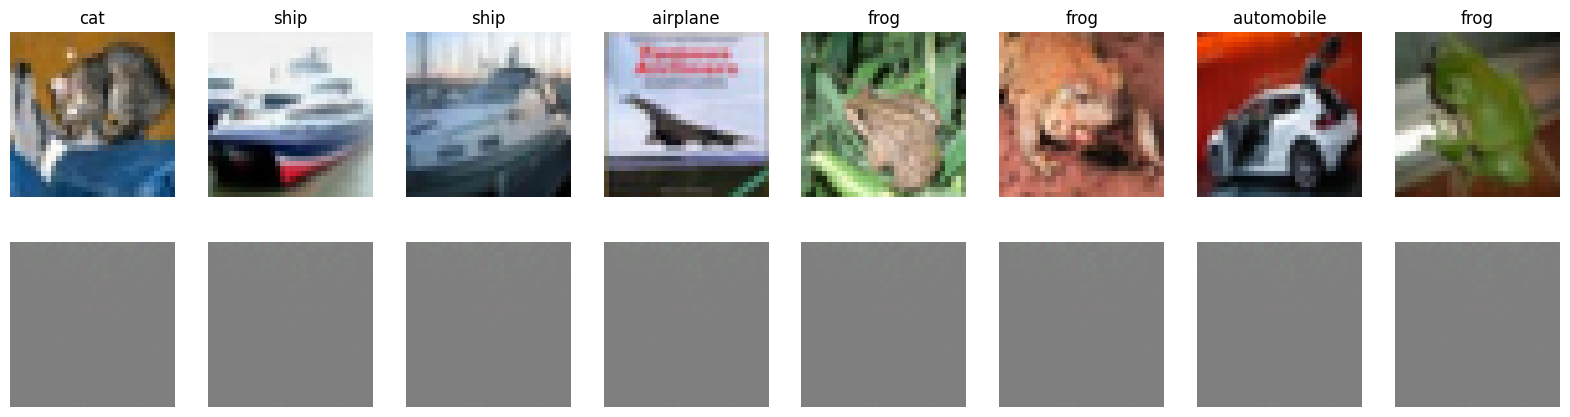

In [25]:
# Plot 8 images (original image) and to their right plot the reconstructed image
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    assert len(images) >= 8, "Test loader must have at least 8 images, got only {}".format(len(images))
    print(images.shape)
    images = images[:8].to(device)

    outputs, _, _ = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    print(outputs.shape)

    fig, axes = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(8):
        # Change the order of the channels to (h, w, c) for matplotlib
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        # Add title for the image
        axes[0, i].set_title(f"{train_dataset.classes[labels[i]]}")
        axes[1, i].imshow(outputs[i].permute(1, 2, 0))
        axes[1, i].axis('off')

    plt.show()